<a href="https://colab.research.google.com/github/pedroteixeirazup/Keras/blob/master/BreastCancer/EvaluateBreastCancerKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.models import load_model

from keras import backend as K

from io import BytesIO
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors

import requests

K.set_learning_phase(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Data/model.00-0.75.hdf5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
eval_datagen = ImageDataGenerator(rescale=1./255)
eval_dir = '/content/drive/My Drive/Colab Notebooks/Data/eval'
eval_generator = eval_datagen.flow_from_directory(eval_dir, target_size=(255,255), batch_size=32, class_mode='categorical')

loss = model.evaluate_generator(eval_generator,steps=10)
out={}
for index, name in enumerate(model.metrics_names):
    print(name, loss[index])

Found 171 images belonging to 2 classes.
loss 0.570792555809021
accuracy 0.7692307829856873


In [ ]:
classes = ['benign','malign']

def preprocess_input(x):
    x = img_to_array(x) / 255.
    return np.expand_dims(x, axis=0)

def predict_from_image_path(image_path):
    return predict_image(load_img(image_path, target_size=(255,255)))

def predict_image(im):
    x = preprocess_input(im)
    pred = np.argmax(model.predict(x))
    return pred, classes[pred]

In [ ]:
def grad_CAM(image_path):
    im = load_img(image_path, target_size=(255,255))
    x = preprocess_input(im)
    pred = model.predict(x)
    
    # Predicted class index
    index = np.argmax(pred)
    
    # Get the entry of the predicted class
    class_output = model.output[:, index]
    
    # The last convolution layer in Inception V3
    last_conv_layer = model.get_layer('conv2d_188')
    # Has 192 channels
    nmb_channels = last_conv_layer.output.shape[3]

    # Gradient of the predicted class with respect to the output feature map of the 
    # the convolution layer with 192 channels
    grads = K.gradients(class_output, last_conv_layer.output)[0]   
    
    # Vector of shape (192,), where each entry is the mean intensity of the gradient over 
    # a specific feature-map channel”
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Setup a function to extract the desired values
    iterate = K.function(model.inputs, [pooled_grads, last_conv_layer.output[0]])
    # Run the function to get the desired calues
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    # Multiply each channel in the feature-map array by “how important this channel is” with regard to the 
    # predicted class
 
    for i in range(nmb_channels):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    # The channel-wise mean of the resulting feature map is the heatmap of the class activation.
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    # Normalize the heatmap betwen 0 and 1 for visualization
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
       
    # Read the image again, now using cv2
    img = cv2.imread(image_path)
    # Size the heatmap to the size of the loaded image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # Convert to RGB
    heatmap = np.uint8(255 * heatmap)
    # Pseudocolor/false color a grayscale image using OpenCV’s predefined colormaps
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
 
    # Superimpose the image with the required intensity
    superimposed_img = heatmap * 0.5 + img   
    
    # Write the image
    plt.figure(figsize=(24,12))
    cv2.imwrite('./tmp.jpg', superimposed_img)
    plt.imshow(mpimg.imread('./tmp.jpg'))
    plt.show()

(0, 'benign')


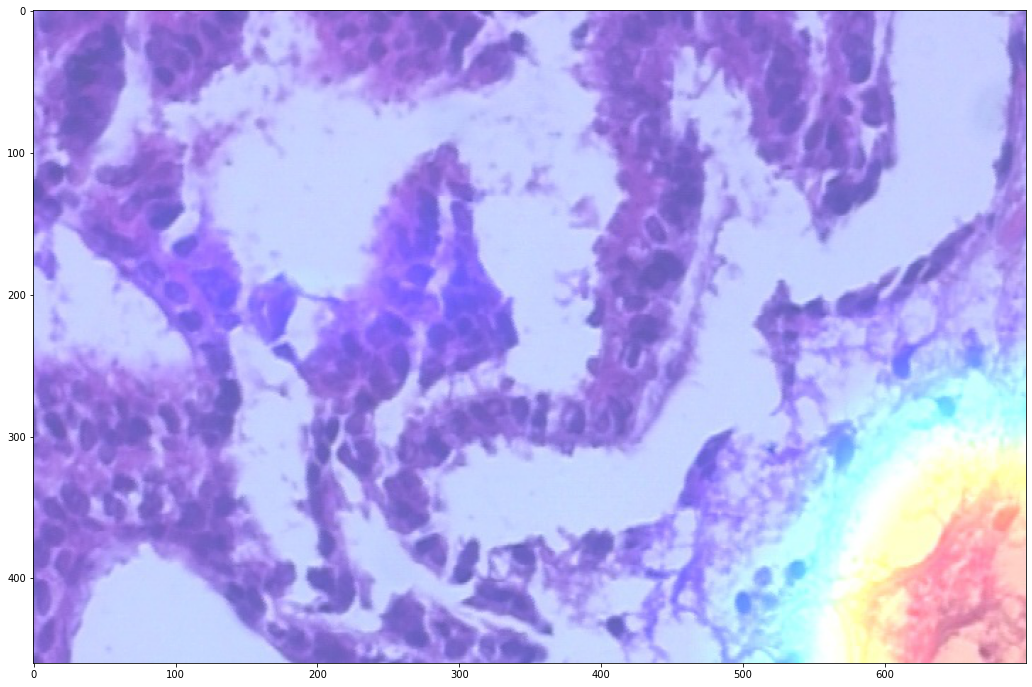

In [ ]:
print(predict_from_image_path('/content/drive/My Drive/Colab Notebooks/Data/eval/benign/SOB_B_A-14-22549G-200-011.png'))
grad_CAM('/content/drive/My Drive/Colab Notebooks/Data/eval/benign/SOB_B_A-14-22549G-200-011.png')